In [41]:
import warnings
warnings.filterwarnings("ignore")

#pip install textblob
from textblob import TextBlob

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 200)


#!pip install python-Levenshtein
from Levenshtein import distance as lev

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import difflib
from IPython import display

#pip install NRCLex
#from nrclex import NRCLex

import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nrclex import NRCLex

In [6]:
"""
*************************BREAKING UP THE DATA*************************
"""
web_page_text = pd.read_csv("web-pages.csv")
web_page_text = web_page_text.dropna()
web_page_text = web_page_text.reset_index()
web_page_text

index  crawl_date             domain  \
0       0       20200408    brocku.ca           
1       1       20200408    cse.google.com      
2       2       20200408    google.com          
3       4       20200408    object.is           
4       5       20200408    w3.org              
...    ..            ...       ...              
634522  756111  20211008    events.pelham.ca    
634523  756117  20211008    thehopecentre.net   
634524  756118  20211008    thehopecentre.net   
634525  756119  20211008    google.com          
634526  756120  20211008    thehopecentre.net   

                                                                                                                                                                                                             url  \
0       https://brocku.ca/coronavirus/                                                                                                                                                                             
1       https://cse.google.com/about                                                                                                                                                                               
2       https://www.google.com/                                                                                                                                                                                    
3       https://object.is/                                                                                                                                                                                         
4       http://www.w3.org/2000/svg                                                                                                                                                                                 
...                            ...                                                                                                                                                                                 
634522  https://events.pelham.ca/Default/Month                                                                                                                                                                     
634523  https://thehopecentre.net/covid-health-updates/                                                                                                                                                            
634524  https://thehopecentre.net/covid-health-updates/                                                                                                                                                            
634525  https://www.google.com/recaptcha/api2/anchor?ar=1&k=6LcHWMAbAAAAAB0EMdTxSAx6zh70tHYySBx4vopw&co=aHR0cHM6Ly90aGVob3BlY2VudHJlLm5ldDo0NDM.&hl=en&v=qljbK_DTcvY1PzbR7IG69z1r&size=invisible&cb=8ivat84d4j95   
634526  https://thehopecentre.net/                                                                                                                                                                                 

       mime_type_web_server mime_type_tika language  \
0       text/html            text/html      en        
1       text/html            text/html      en        
2       text/html            text/html      en        
3       text/html            text/html      is        
4       text/html            text/html      en        
...           ...                  ...      ..        
634522  text/html            text/html      en        
634523  text/html            text/html      en        
634524  text/html            text/html      en        
634525  text/html            text/html      en        
634526  text/html            text/html      en        

                                                                                                                                                                                                                      

In [7]:
web_domain_list = web_page_text['domain'].unique()
web_url_list = web_page_text['url'].unique()
print('web_domain_list: ', len(web_domain_list), '\t/web_url_list: ', len(web_url_list))

web_domain_list:  2568 	\web_url_list:  71832


In [15]:
domain_list = pd.DataFrame(columns={'domain', 'length'})

for i in range(0, len(web_domain_list)):
    temp_df = web_page_text[web_page_text['domain'] == web_domain_list[i]]
    domain_list.loc[i, 'domain'] = web_domain_list[i]
    domain_list.loc[i, 'length'] = len(temp_df)

domain_list = domain_list.sort_values(by=['length'], ascending=True)
domain_list = domain_list[domain_list['length'] > 10].reset_index()
domain_list

,level_0,index,domain,length
0,861,2106,dequeuniversity.com,11
1,855,327,widget.surveymonkey.com,11
2,856,2309,cashier.wixapps.net,11
3,860,734,presstimedesign.com,11
4,858,1352,tumblr.com,11
...,...,...,...,...
857,4,257,portcolborne.ca,24996
858,3,44,youtube.com,41832
859,2,326,gncc.ca,43868
860,1,8,twitter.com,62434


In [17]:
"""
***************************SENTIMENT ANALYSIS***************************
"""
#creating a function to obtain the polarity and subjectivity from the content column, using TextBlob
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity


#assigning an adjective to the sentiment calcuations, for the purpose of grouping and not having to manage the different floats
def assignPolarity(polarity):
    if polarity > 0:
        return "Positive"
    elif polarity == 0:
        return "Neutral"
    else:
        return "Negative"

def assignSubjectivity(subjectivity):
    if subjectivity > 0.5:
        return "Subjective"
    elif subjectivity == 0.5:
        return "Neutral"
    else:
        return "Objective"

In [19]:
sentiment_df = pd.DataFrame(columns={'crawl_date', 'domain', 'url', 'content', 'polarity', 'polarity_type', 'subjectivity', 'subjectivity_type'})

for i in range(0, len(domain_list)):
    domain = domain_list.loc[i, 'domain']
    file_name = domain.replace('.', '_')
    new_df = web_page_text[web_page_text['domain'] == domain]

    new_df['polarity'] = new_df['content'].apply(getPolarity)
    new_df['subjectivity'] = new_df['content'].apply(getSubjectivity)
    new_df['polarity_type'] = new_df['polarity'].apply(assignPolarity)
    new_df['subjectivity_type'] = new_df['subjectivity'].apply(assignSubjectivity)
    
    sentiment_df = sentiment_df.append(new_df[['crawl_date', 'domain', 'url', 'content', 'polarity', 'polarity_type', 'subjectivity', 'subjectivity_type']])
    
    new_df.to_csv('OneDrive - Brock University/SCHOOL/YEAR 3/RESEARCH_2/' +file_name+ '.csv',index=False)
    print(i, '\t', domain, ' completed\t', len(new_df))

0 	 dequeuniversity.com  completed	 11
1 	 widget.surveymonkey.com  completed	 11
2 	 cashier.wixapps.net  completed	 11
3 	 presstimedesign.com  completed	 11
4 	 tumblr.com  completed	 11
5 	 upgrade.com  completed	 11
6 	 globalroadwarrior.com  completed	 11
7 	 v2.wp-api.org  completed	 12
8 	 libraryaware.com  completed	 12
9 	 ola.org  completed	 12
10 	 ak.ai  completed	 12
11 	 yourchannel.welland.ca  completed	 12
12 	 lightwidget.com  completed	 12
13 	 infoflow.baidu.com  completed	 12
14 	 mariages.net  completed	 12
15 	 casamentos.pt  completed	 13
16 	 mnp.ca  completed	 13
17 	 creatoracademy.youtube.com  completed	 13
18 	 casamentos.com.br  completed	 13
19 	 cbc.news.ca  completed	 13
20 	 macleans.ca  completed	 14
21 	 laposte.fr  completed	 14
22 	 digitalmainstreet.ca  completed	 14
23 	 ca.reuters.com  completed	 14
24 	 artists.youtube.com  completed	 14
25 	 janiceandrobin.com  completed	 14
26 	 follow.it  completed	 14
27 	 matrimonio.com  completed	 14
28 	

217 	 canterburyhillscamp.ca  completed	 18
218 	 niagaracollegewine.ca  completed	 18
219 	 mailinator.com  completed	 18
220 	 soundboxpro.com  completed	 18
221 	 telus.com  completed	 18
222 	 webmail.xtra.co.nz  completed	 18
223 	 its.niagaracollege.ca  completed	 19
224 	 sina.com  completed	 19
225 	 dailymotion.com  completed	 19
226 	 forterie-test.evergreencatalog.com  completed	 20
227 	 login.mailchimp.com  completed	 20
228 	 mail.yahoo.com  completed	 20
229 	 thewalrus.ca  completed	 20
230 	 ceba-cuec.ca  completed	 20
231 	 arnet.com.ar  completed	 20
232 	 squarespace.com  completed	 21
233 	 exosite.com  completed	 21
234 	 omny.fm  completed	 21
235 	 vox.com  completed	 21
236 	 lincoln.library.on.ca  completed	 22
237 	 editor.wixapps.net  completed	 22
238 	 ontariocolleges.ca  completed	 22
239 	 gmpg.org  completed	 22
240 	 weebly.com  completed	 22
241 	 openhouse.niagaracollege.ca  completed	 23
242 	 tatacliq.com  completed	 23
243 	 bankofcanada.ca  compl

442 	 gov.uk  completed	 45
443 	 npca.ca  completed	 45
444 	 player.twitch.tv  completed	 45
445 	 facilities.thorold.ca  completed	 45
446 	 midwesternnewspapers.com  completed	 46
447 	 outlook.office365.com  completed	 46
448 	 eventbrite.com.pe  completed	 47
449 	 eventbrite.dk  completed	 47
450 	 eventbrite.it  completed	 47
451 	 eventbrite.es  completed	 47
452 	 eventbrite.hk  completed	 47
453 	 eventbrite.at  completed	 47
454 	 211ontario.ca  completed	 47
455 	 aws.amazon.com  completed	 47
456 	 laredoute.fr  completed	 47
457 	 jsdelivr.com  completed	 48
458 	 eventbrite.se  completed	 48
459 	 eventbrite.com.mx  completed	 48
460 	 cal.nflibrary.ca  completed	 48
461 	 eventbrite.com.au  completed	 48
462 	 eventbrite.fr  completed	 48
463 	 eventbrite.cl  completed	 48
464 	 facebook.com  completed	 48
465 	 ncteachingwinery.ca  completed	 48
466 	 eventbrite.pt  completed	 48
467 	 wbfo.org  completed	 48
468 	 eventbrite.nl  completed	 49
469 	 eventbrite.fi  com

659 	 constantcontact.com  completed	 85
660 	 hnhbhealthline.ca  completed	 86
661 	 jobgym.com  completed	 86
662 	 reuters.com  completed	 90
663 	 futureaccess.ca  completed	 90
664 	 northbaynipissing.com  completed	 91
665 	 apple.com  completed	 91
666 	 speakupontario.ca  completed	 91
667 	 varsityblues.universitytickets.com  completed	 92
668 	 waterloochronicle.ca  completed	 92
669 	 pathstonementalhealth.ca  completed	 93
670 	 mailchimp.com  completed	 94
671 	 pollicemanagement.com  completed	 94
672 	 youtube-nocookie.com  completed	 95
673 	 tv.youtube.com  completed	 95
674 	 womensplacesn.org  completed	 96
675 	 news.wbfo.org  completed	 96
676 	 memberservices.membee.com  completed	 96
677 	 eventbrite.be  completed	 96
678 	 hbr.org  completed	 99
679 	 eventbrite.ch  completed	 100
680 	 progallery.wixapps.net  completed	 101
681 	 teams.microsoft.com  completed	 104
682 	 sorrywereclosed2020.com  completed	 106
683 	 docs.google.com  completed	 106
684 	 toronto

In [ ]:
sentiment_df.to_csv('OneDrive - Brock University/SCHOOL/YEAR 3/RESEARCH_2/ALL_SENTIMENTS.csv')

In [74]:
"""
***********************ANALYZING THE DATA************************
"""
sentiment_df = 'OneDrive - Brock University/SCHOOL/YEAR 3/RESEARCH_2/ALL_SENTIMENTS.csv'

web_page_text = pd.read_csv(sentiment_df)
web_page_text = web_page_text.dropna()
web_page_text = web_page_text.reset_index()
web_page_text = web_page_text[['crawl_date', 'domain', 'url', 'polarity', 'polarity_type', 'subjectivity', 'subjectivity_type']]

web_page_text['crawl_date']= pd.to_datetime(web_page_text['crawl_date'],format='%Y%m%d')
web_page_text = web_page_text.sort_values(by=['url', 'crawl_date'], ascending=[True, False])
web_page_text.sample(1)

,crawl_date,domain,url,polarity,polarity_type,subjectivity,subjectivity_type
154634,2020-05-29,thehopecentre.net,https://www.thehopecentre.net/covid-19/bb3fb8_f436286e4539427639b58a484f252196_1192.json,0.028238,Positive,0.585571,Subjective


In [75]:
crawl_date_sentiment = web_page_text.groupby(['crawl_date']).mean()
crawl_date_sentiment = crawl_date_sentiment.rename(columns={'polarity': 'avg_polarity', 'subjectivity': 'avg_subjectivity'})

crawl_date_domain_sentiment = web_page_text.groupby(['crawl_date', 'domain']).mean()
crawl_date_url_sentiment = web_page_text.groupby(['crawl_date', 'domain', 'url']).mean()


In [76]:
low_polarity = web_page_text.groupby(web_page_text['crawl_date'])['polarity'].min()
high_polarity = web_page_text.groupby(web_page_text['crawl_date'])['polarity'].max()

low_subjectivity = web_page_text.groupby(web_page_text['crawl_date'])['subjectivity'].min()
high_subjectivity = web_page_text.groupby(web_page_text['crawl_date'])['subjectivity'].max()

In [77]:
crawl_date_sentiment = crawl_date_sentiment.merge(low_polarity, left_index=True, right_on='crawl_date')
crawl_date_sentiment = crawl_date_sentiment.merge(low_subjectivity, left_index=True, right_on='crawl_date')
crawl_date_sentiment = crawl_date_sentiment.rename(columns={'polarity': 'min_polarity', 'subjectivity': 'min_subjectivity'})


crawl_date_sentiment = crawl_date_sentiment.merge(high_subjectivity, left_index=True, right_on='crawl_date')
crawl_date_sentiment = crawl_date_sentiment.merge(high_polarity, left_index=True, right_on='crawl_date')
crawl_date_sentiment = crawl_date_sentiment.rename(columns={'polarity': 'max_polarity', 'subjectivity': 'max_subjectivity'})


In [78]:
export_path = 'OneDrive - Brock University/SCHOOL/YEAR 3/RESEARCH_2/'

web_page_text.to_excel(export_path+ 'SENTIMENTS_ONLY.xlsx')
crawl_date_domain_sentiment.to_excel(export_path+ 'SENTIMENTS_DOMAIN.xlsx')
crawl_date_url_sentiment.to_excel(export_path+ 'SENTIMENTS_URL.xlsx')
crawl_date_sentiment.to_excel(export_path+ 'SENTIMENTS_CRAWL_DATE.xlsx')

In [20]:
"""
**********************ANALYZING FOR EMOTIONS**********************
"""
text = ['hate', 'lovely', 'person', 'worst']

for i in range(len(text)):
    emotion = NRCLex(text[i])
    content_emotions = ['']
    
    emotion_list = emotion.top_emotions
    for j in range(0, len(emotion_list)):
        content_emotions.append(emotion_list[j])
        print(content_emotions)
    # Classify emotion
    print('\n\n', text[i], ': ', emotion.top_emotions, len(emotion.top_emotions))

['', ('fear', 0.2)]
['', ('fear', 0.2), ('anger', 0.2)]
['', ('fear', 0.2), ('anger', 0.2), ('negative', 0.2)]
['', ('fear', 0.2), ('anger', 0.2), ('negative', 0.2), ('sadness', 0.2)]
['', ('fear', 0.2), ('anger', 0.2), ('negative', 0.2), ('sadness', 0.2), ('disgust', 0.2)]


 hate :  [('fear', 0.2), ('anger', 0.2), ('negative', 0.2), ('sadness', 0.2), ('disgust', 0.2)] 5
['', ('trust', 0.16666666666666666)]
['', ('trust', 0.16666666666666666), ('surprise', 0.16666666666666666)]
['', ('trust', 0.16666666666666666), ('surprise', 0.16666666666666666), ('positive', 0.16666666666666666)]
['', ('trust', 0.16666666666666666), ('surprise', 0.16666666666666666), ('positive', 0.16666666666666666), ('sadness', 0.16666666666666666)]
['', ('trust', 0.16666666666666666), ('surprise', 0.16666666666666666), ('positive', 0.16666666666666666), ('sadness', 0.16666666666666666), ('joy', 0.16666666666666666)]
['', ('trust', 0.16666666666666666), ('surprise', 0.16666666666666666), ('positive', 0.1666666666

In [25]:
def get_emotions(text):
    #content_emotions = ['']
    content_emotions = ''
    
    for i in range(len(text)):
        emotion = NRCLex(text[i])
        emotion_list = emotion.top_emotions
        
        for j in range(0, len(emotion_list)):
            #content_emotions.append(str(emotion_list[j]))
            content_emotions = content_emotions + '\t' + emotion_list[j]
            print(emotion_list[j])
    
    return content_emotions
        
        
sentiment_df['emotions'] = sentiment_df['content'].apply(get_emotions, axis=1)

TypeError: string indices must be integers

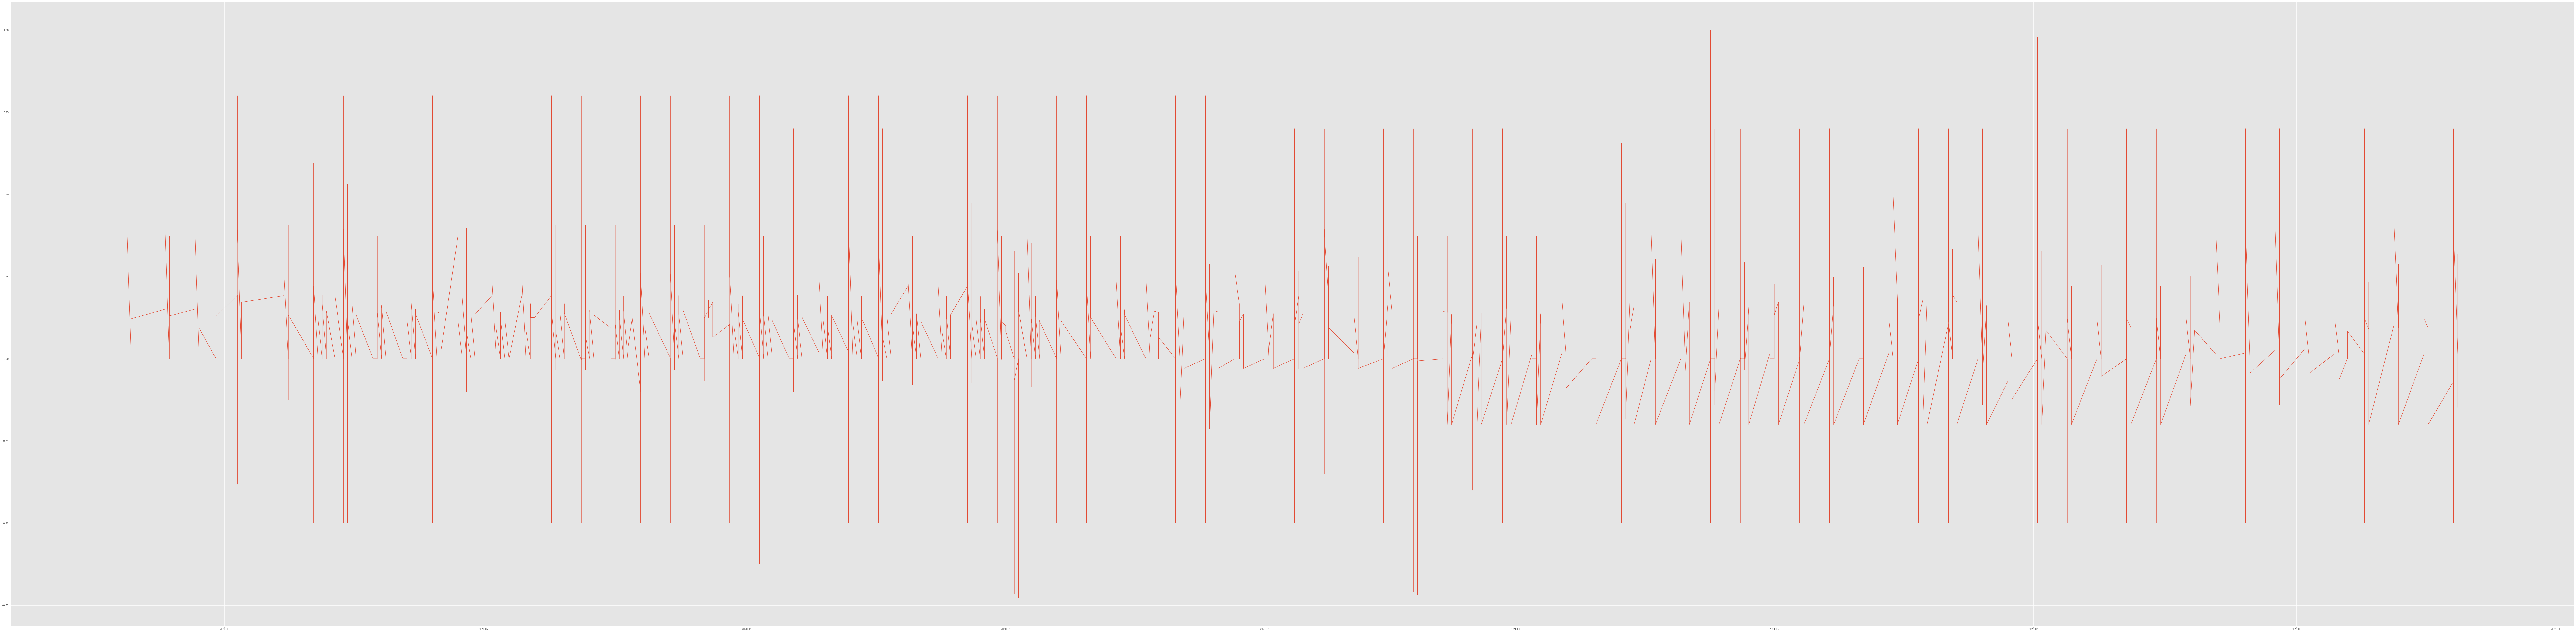

In [49]:
"""
***********************PLOTTING DOMAIN SENTIMENT***********************
"""
export_path = 'OneDrive - Brock University/SCHOOL/YEAR 3/RESEARCH_2/'
crawl_date_domain_sentiment = pd.read_excel(export_path+ 'SENTIMENTS_DOMAIN.xlsx')

plt.style.use('ggplot')
plt.figure(figsize = (200, 50))
plt.plot(crawl_date_domain_sentiment['crawl_date'], crawl_date_domain_sentiment['polarity'])
#plt.title(url_link+ ' Polarity Analysis')